In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import time
import plotly.graph_objects as go
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpInteger, LpStatus, value, CPLEX_CMD
import networkx as nx
from ortools.constraint_solver import pywrapcp, routing_enums_pb2, pywraplp
import itertools


colors = ['#9E2A2B', '#bf6535', '#e09f3e', '#f0c977', '#fff3b0', '#ccce9e', '#99a88c', '#335c67']

In [4]:
file = pd.ExcelFile(r'C:\Users\tomol\OneDrive\Desktop\Supply chain logisitcs problem.xlsx')
df_dict = {}
for names in file.sheet_names:
    globals()[names] = file.parse(names)
    df_dict[names] = globals()[names]
print(df_dict.keys())

dict_keys(['OrderList', 'FreightRates', 'WhCosts', 'WhCapacities', 'ProductsPerPlant', 'VmiCustomers', 'PlantPorts'])


# 1. Data description

We will start by understanding what is within the excel file and what information are in the various sheets.

In [5]:
def description(df_name, df):
    print(f"{df_name}:\n")
    print(f"Rows: {df.shape[0]}")
    print(f"Columns: {df.shape[1]}")
    print("Column names:")
    print(df.columns.tolist())
    print("\n" + "-"*80 + "\n")
for df_name, df in df_dict.items():
    description(df_name, df)

OrderList:

Rows: 9215
Columns: 14
Column names:
['Order ID', 'Order Date', 'Origin Port', 'Carrier', 'TPT', 'Service Level', 'Ship ahead day count', 'Ship Late Day count', 'Customer', 'Product ID', 'Plant Code', 'Destination Port', 'Unit quantity', 'Weight']

--------------------------------------------------------------------------------

FreightRates:

Rows: 1540
Columns: 11
Column names:
['Carrier', 'orig_port_cd', 'dest_port_cd', 'minm_wgh_qty', 'max_wgh_qty', 'svc_cd', 'minimum cost', 'rate', 'mode_dsc', 'tpt_day_cnt', 'Carrier type']

--------------------------------------------------------------------------------

WhCosts:

Rows: 19
Columns: 2
Column names:
['WH', 'Cost/unit']

--------------------------------------------------------------------------------

WhCapacities:

Rows: 19
Columns: 2
Column names:
['Plant ID', 'Daily Capacity ']

--------------------------------------------------------------------------------

ProductsPerPlant:

Rows: 2036
Columns: 2
Column names:
['Pl

### Statistical Description

In [6]:
print("Statistical Description for OrderList:\n")
print(OrderList.describe())
print("\n" + "-"*80 + "\n")

Statistical Description for OrderList:

           Order ID           Order Date          TPT  Ship ahead day count  \
count  9.215000e+03                 9215  9215.000000           9215.000000   
mean   1.447274e+09  2013-05-26 00:00:00     1.717743              1.852306   
min    1.447126e+09  2013-05-26 00:00:00     0.000000              0.000000   
25%    1.447197e+09  2013-05-26 00:00:00     1.000000              0.000000   
50%    1.447276e+09  2013-05-26 00:00:00     2.000000              3.000000   
75%    1.447346e+09  2013-05-26 00:00:00     2.000000              3.000000   
max    1.447425e+09  2013-05-26 00:00:00     4.000000              6.000000   
std    8.381629e+04                  NaN     0.630500              1.922302   

       Ship Late Day count    Product ID  Unit quantity       Weight  
count          9215.000000  9.215000e+03    9215.000000  9215.000000  
mean              0.039935  1.680536e+06    3202.747151    19.871688  
min               0.000000  1.61332

#### Check for Duplicates & Null Values

In [7]:
def check_duplicate_values(df_name, df):
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        print(f"Duplicate Values in {df_name}: {duplicate_count}")
    print("\n" + "-"*80 + "\n")

def check_missing_values(df_name, df):
    print(f"Missing Values in {df_name}:\n")
    print(df.isnull().sum())
    print("\n" + "-"*80 + "\n")

for df_name, df in df_dict.items():
    check_missing_values(df_name, df)
    check_duplicate_values(df_name, df)


Missing Values in OrderList:

Order ID                0
Order Date              0
Origin Port             0
Carrier                 0
TPT                     0
Service Level           0
Ship ahead day count    0
Ship Late Day count     0
Customer                0
Product ID              0
Plant Code              0
Destination Port        0
Unit quantity           0
Weight                  0
dtype: int64

--------------------------------------------------------------------------------


--------------------------------------------------------------------------------

Missing Values in FreightRates:

Carrier         0
orig_port_cd    0
dest_port_cd    0
minm_wgh_qty    0
max_wgh_qty     0
svc_cd          0
minimum cost    0
rate            0
mode_dsc        0
tpt_day_cnt     0
Carrier type    0
dtype: int64

--------------------------------------------------------------------------------

Duplicate Values in FreightRates: 3

---------------------------------------------------------------

In [8]:
for df_name, df in df_dict.items():
    df.columns = [col.strip().replace(' ', '_').replace('/', '_').lower() for col in df.columns]

# 2. Data Visualisation

In [9]:
OrderList['order_date'] = pd.to_datetime(OrderList['order_date'])
unique_date = OrderList['order_date'].unique()
if len(unique_date) == 1:
    print(f"We will be working with data from a specific day: {unique_date[0]}")
else:
    print(f"We will be working with data across multiple days: {unique_date}")

We will be working with data from a specific day: 2013-05-26 00:00:00


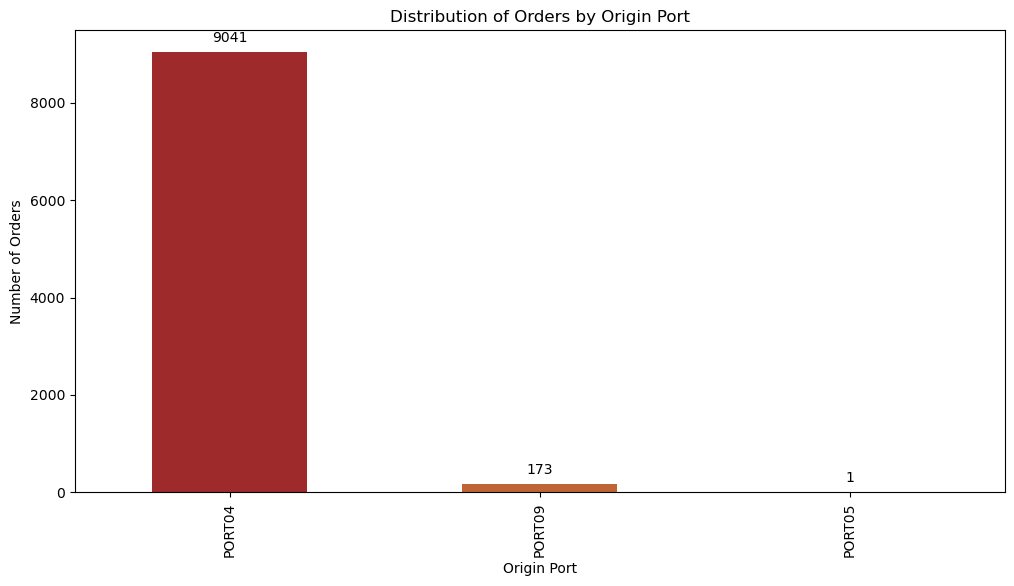

In [10]:
plt.figure(figsize=(12, 6))
ax = OrderList['origin_port'].value_counts().plot(kind='bar', color=colors)
plt.title('Distribution of Orders by Origin Port')
plt.xlabel('Origin Port')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.show()

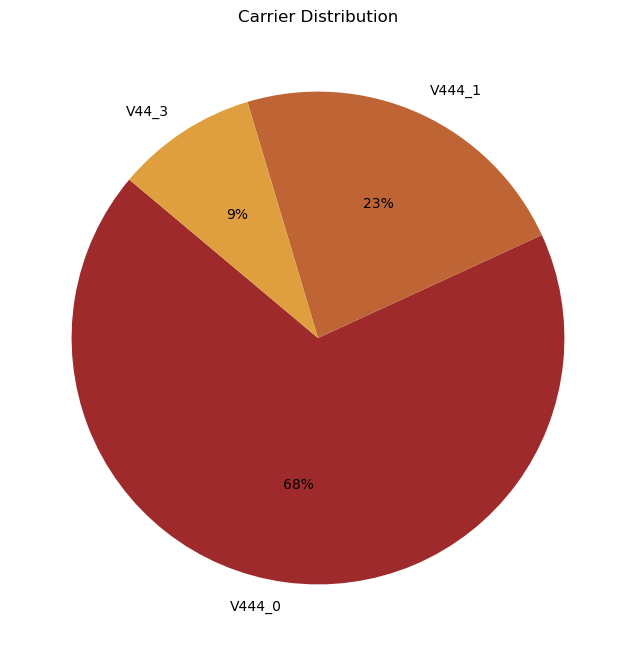

In [11]:
plt.figure(figsize=(8, 8))
OrderList['carrier'].value_counts().plot(
    kind='pie', 
    autopct=lambda p: f'{p:.0f}%',  
    startangle=140, 
    colors=colors)
plt.title('Carrier Distribution')
plt.ylabel('')
plt.show()

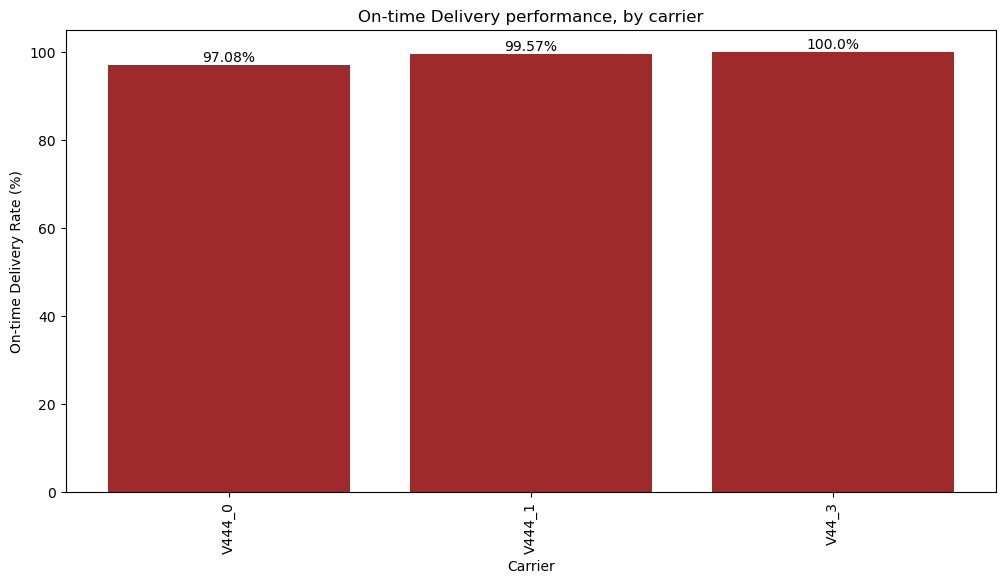

In [12]:
OrderList['on_time_delivery'] = OrderList['ship_late_day_count'] <= 0
carrier_performance = OrderList.groupby('carrier')['on_time_delivery'].mean().reset_index()
carrier_performance['on_time_delivery'] = carrier_performance['on_time_delivery'] * 100
plt.figure(figsize=(12, 6))
bars = plt.bar(carrier_performance['carrier'], carrier_performance['on_time_delivery'], color=colors[0])
plt.title('On-time Delivery performance, by carrier')
plt.xlabel('Carrier')
plt.ylabel('On-time Delivery Rate (%)')
plt.xticks(rotation=90)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{round(yval, 2)}%', ha='center', va='bottom')
plt.show()

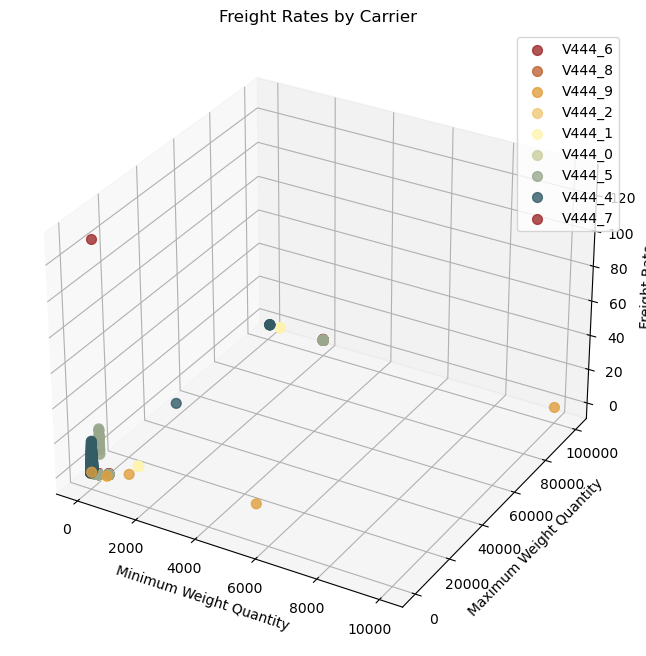

In [13]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

carriers = FreightRates['carrier'].unique()
for i, carrier in enumerate(carriers):
    carrier_data = FreightRates[FreightRates['carrier'] == carrier]
    ax.scatter(
        carrier_data['minm_wgh_qty'], 
        carrier_data['max_wgh_qty'], 
        carrier_data['rate'], 
        color=colors[i % len(colors)], 
        s=50, 
        alpha=0.8,
        label=carrier)
ax.set_title('Freight Rates by Carrier')
ax.set_xlabel('Minimum Weight Quantity')
ax.set_ylabel('Maximum Weight Quantity')
ax.set_zlabel('Freight Rate')

ax.legend()
plt.show()

##### NOTE: On jupyter notebook, there is no option to zoom into the graph. However, on any other IDE, this would be practical to see clearly the rate of each min. and max. weight quantity associated to each carrier. 

C:\Users\tomol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\tomol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\tomol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


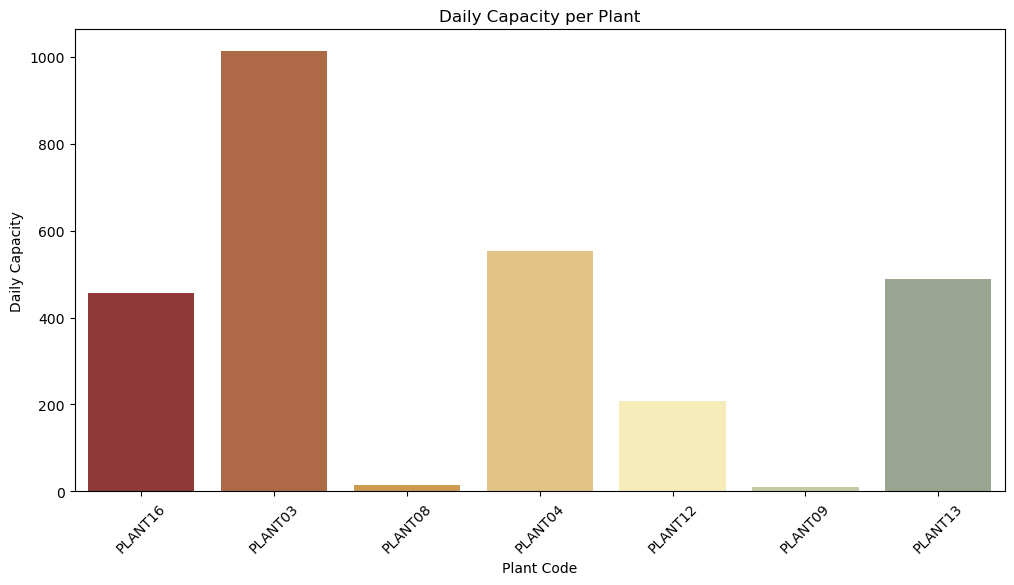

In [14]:
order_capacity = OrderList.merge(WhCapacities, left_on='plant_code', right_on='plant_id', how='left')
daily_capacity_per_plant = order_capacity[['plant_code', 'daily_capacity']].drop_duplicates()

plt.figure(figsize=(12, 6))
sns.barplot(x='plant_code', y='daily_capacity', data=daily_capacity_per_plant, palette=colors)
plt.title('Daily Capacity per Plant')
plt.xlabel('Plant Code')
plt.ylabel('Daily Capacity')
plt.xticks(rotation=45)
plt.show()

#### Merging *OrderList* with *FreightRates* and *df_WhCosts*, and calculating the **Total Cost**

In [15]:
OrderList = df_dict['OrderList']

OrderList = OrderList.merge(df_dict['FreightRates'], left_on=['carrier', 'origin_port', 'destination_port'],
                            right_on=['carrier', 'orig_port_cd', 'dest_port_cd'], how='left')
OrderList = OrderList.merge(df_dict['WhCosts'], left_on='plant_code', right_on='wh', how='left')

OrderList['cost'] = (OrderList['unit_quantity'] * OrderList['rate']) + (OrderList['unit_quantity'] * OrderList['cost_unit'])

OrderList = OrderList.dropna() 

ProductsPerPlant = df_dict['ProductsPerPlant']
ProductsPerPlant = ProductsPerPlant.dropna() 

df_dict['OrderList'] = OrderList
df_dict['ProductsPerPlant'] = ProductsPerPlant

OrderList

,order_id,order_date,origin_port,carrier,tpt,service_level,ship_ahead_day_count,ship_late_day_count,customer,product_id,...,max_wgh_qty,svc_cd,minimum_cost,rate,mode_dsc,tpt_day_cnt,carrier_type,wh,cost_unit,cost
854,1.447385e+09,2013-05-26,PORT09,V444_0,0,DTP,0,0,V55555_4,1692724,...,5000.00,DTP,31.2784,12.2784,GROUND,0.0,V88888888_0,PLANT16,1.919808,4713.804893
855,1.447385e+09,2013-05-26,PORT09,V444_0,0,DTP,0,0,V55555_4,1692724,...,5000.00,DTD,31.2784,13.2784,GROUND,0.0,V88888888_0,PLANT16,1.919808,5045.804893
856,1.447338e+09,2013-05-26,PORT09,V444_0,0,DTP,0,0,V55555_4,1692724,...,5000.00,DTP,31.2784,12.2784,GROUND,0.0,V88888888_0,PLANT16,1.919808,5082.958288
857,1.447338e+09,2013-05-26,PORT09,V444_0,0,DTP,0,0,V55555_4,1692724,...,5000.00,DTD,31.2784,13.2784,GROUND,0.0,V88888888_0,PLANT16,1.919808,5440.958288
858,1.447407e+09,2013-05-26,PORT09,V444_0,0,DTP,3,0,V555555_6,1692722,...,5000.00,DTP,31.2784,12.2784,GROUND,0.0,V88888888_0,PLANT16,1.919808,5807.066871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209397,1.447328e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683424,...,99.99,DTD,7.8044,0.0804,AIR,1.0,V888888883_1,PLANT03,0.517502,189.534900
209398,1.447328e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683424,...,299.99,DTD,11.2272,0.0792,AIR,1.0,V888888883_1,PLANT03,0.517502,189.154500
209399,1.447328e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683424,...,499.99,DTD,31.2672,0.0780,AIR,1.0,V888888883_1,PLANT03,0.517502,188.774100
209400,1.447328e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683424,...,999.99,DTD,49.4272,0.0760,AIR,1.0,V888888883_1,PLANT03,0.517502,188.140100


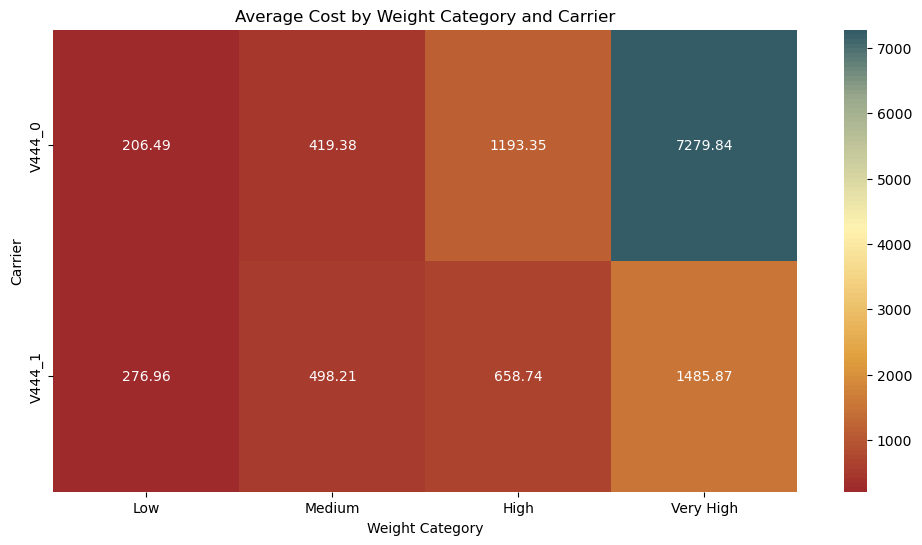

In [16]:
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

OrderList['weight_category'] = pd.qcut(OrderList['weight'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

heatmap_data = OrderList.pivot_table(index='carrier', columns='weight_category', values='cost', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=cmap)
plt.title('Average Cost by Weight Category and Carrier')
plt.xlabel('Weight Category')
plt.ylabel('Carrier')
plt.show()

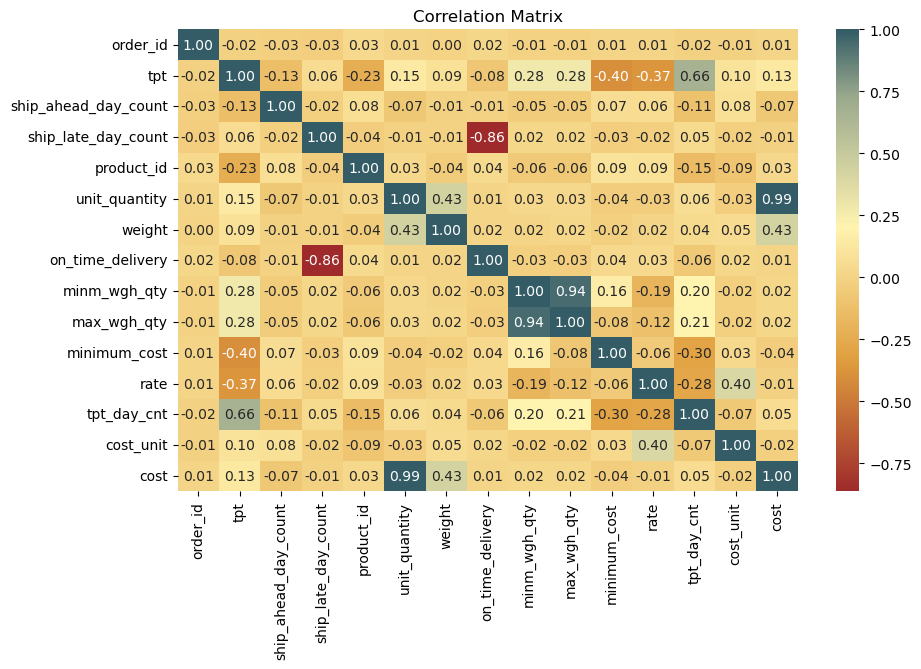

In [17]:
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
correlation_matrix = df_dict['OrderList'].corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=correlation_matrix.round(2), cmap=custom_cmap, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Displaying Network

#### Available connection from our data

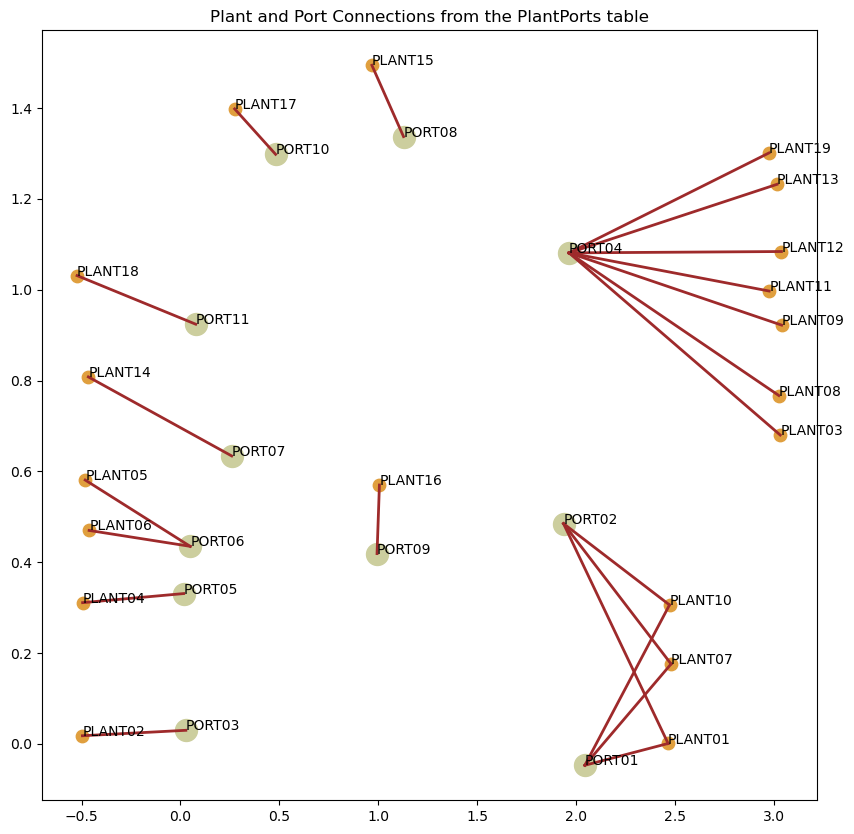

In [18]:
PortsPos = {
    'PORT01': (2.045, -0.047),
    'PORT02': (1.937, 0.485),
    'PORT03': (0.027, 0.03),
    'PORT04': (1.965, 1.081),
    'PORT05': (0.016, 0.331),
    'PORT06': (0.049, 0.435),
    'PORT07': (0.259, 0.634),
    'PORT08': (1.128, 1.337),
    'PORT09': (0.994, 0.419),
    'PORT10': (0.481, 1.298),
    'PORT11': (0.077, 0.924)
}

PlantsPos = {
    'PLANT01': (2.466, 0.001),
    'PLANT02': (-0.496, 0.018),
    'PLANT03': (3.033, 0.68),
    'PLANT04': (-0.495, 0.311),
    'PLANT05': (-0.482, 0.581),
    'PLANT06': (-0.462, 0.47),
    'PLANT07': (2.481, 0.176),
    'PLANT08': (3.026, 0.767),
    'PLANT09': (3.04, 0.922),
    'PLANT10': (2.473, 0.306),
    'PLANT11': (2.977, 0.997),
    'PLANT12': (3.039, 1.084),
    'PLANT13': (3.017, 1.232),
    'PLANT14': (-0.466, 0.808),
    'PLANT15': (0.968, 1.494),
    'PLANT16': (1.006, 0.57),
    'PLANT17': (0.274, 1.398),
    'PLANT18': (-0.523, 1.031),
    'PLANT19': (2.976, 1.301)
}

plants = PlantPorts['plant_code'].unique()
ports = PlantPorts['port'].unique()

port_plants = {port: PlantPorts[PlantPorts['port'] == port]['plant_code'].tolist() for port in ports}

line_color = colors[0]  
port_dot_color = colors[5]  
plant_dot_color = colors[2] 

plt.figure(figsize=(10, 10))

for port in ports:
    if len(port_plants[port]) > 0:
        for plant in port_plants[port]:
            plt.plot([PortsPos[port][0], PlantsPos[plant][0]], 
                     [PortsPos[port][1], PlantsPos[plant][1]], 
                     linewidth=2, c=line_color)

plt.scatter([pos[0] for _, pos in PortsPos.items()], 
            [pos[1] for _, pos in PortsPos.items()], 
            s=250, c=port_dot_color)

for port in ports:
    plt.annotate(port, PortsPos[port], fontsize=10)

plt.scatter([pos[0] for _, pos in PlantsPos.items()], 
            [pos[1] for _, pos in PlantsPos.items()], 
            s=80, c=plant_dot_color)

for plant in plants:
    plt.annotate(plant, PlantsPos[plant], fontsize=10)

plt.title('Plant and Port Connections from the PlantPorts table')
plt.show()


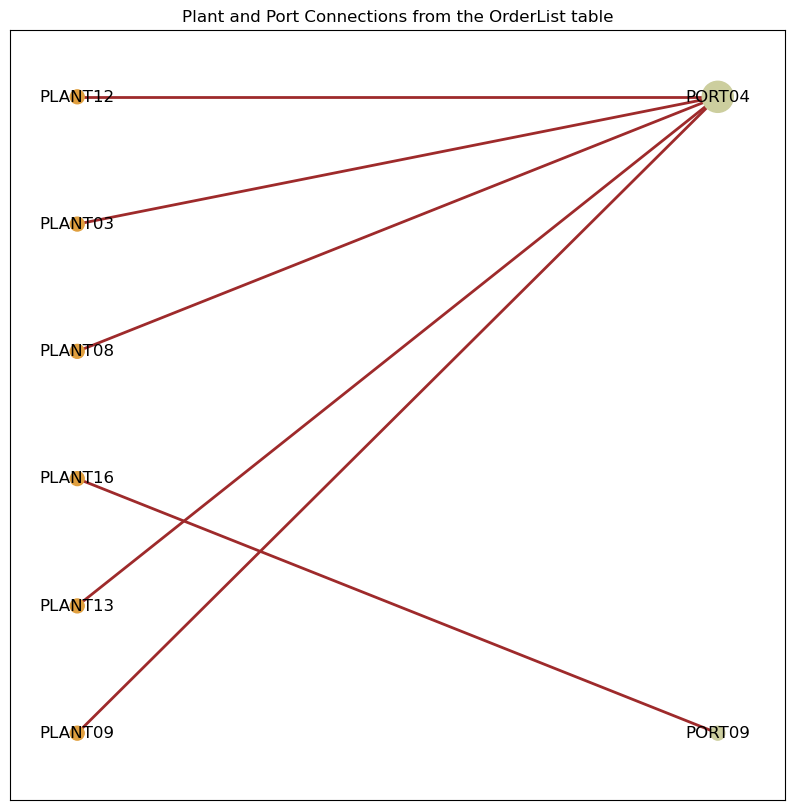

In [19]:
unique_routes = OrderList[['plant_code', 'origin_port']].drop_duplicates()
plant_ports_graph = nx.Graph()

plants = unique_routes['plant_code'].unique()
ports = unique_routes['origin_port'].unique()

plant_ports_graph.add_nodes_from(plants, bipartite=0)
plant_ports_graph.add_nodes_from(ports, bipartite=1)

for _, row in unique_routes.iterrows():
    plant_ports_graph.add_edge(row['plant_code'], row['origin_port'])

layout = nx.bipartite_layout(plant_ports_graph, plants)

for node in layout:
    if node in plants:
        layout[node][0] -= 0.1  
    else:
        layout[node][0] += 0.1  

degrees = dict(plant_ports_graph.degree)

plant_sizes = [degrees[plant] * 100 for plant in plants]
port_sizes = [degrees[port] * 100 for port in ports]

line_color = colors[0]
port_dot_color = colors[5]
plant_dot_color = colors[2]

plt.figure(figsize=(10, 10))

nx.draw_networkx_edges(plant_ports_graph, layout, edge_color=line_color, width=2)

nx.draw_networkx_nodes(plant_ports_graph, layout, nodelist=ports, node_size=port_sizes, node_color=port_dot_color)

nx.draw_networkx_nodes(plant_ports_graph, layout, nodelist=plants, node_size=plant_sizes, node_color=plant_dot_color)

nx.draw_networkx_labels(plant_ports_graph, layout)

plt.title('Plant and Port Connections from the OrderList table')
plt.show()


In [20]:
unique_order_routes = OrderList[['plant_code', 'origin_port']].drop_duplicates()
print(f"Number of unique routing options in OrderList: {unique_order_routes.shape[0]}")
unique_plantport_routes = PlantPorts[['plant_code', 'port']].drop_duplicates()
print(f"Number of unique routing options in PlantPorts: {unique_plantport_routes.shape[0]}")

Number of unique routing options in OrderList: 6
Number of unique routing options in PlantPorts: 22


# II. Optimization

## 1. Constraints

#### Objective Function

The objective function to minimize can be displayed as the following: 

$$ Minimize: 
\sum_{}^{} \left( WC_{ki} + TC_{kpi} \right)
$$

Having:

$$ WC = \sum_{kijp} c^{WC}_{kijp} X_{kijp} $$
$$ TC = \sum_{kijp} c^{TC}_{kijp} X_{kijp} $$

#### Constraints

####  From the **WhCapacity** table:

$$
\sum_{}^{} O_{ki} \leq C_i
$$

where:

- $ O_{ki} $ is a Boolean variable equal to **1** if order $ k $ is shipped from warehouse $ i $ and **0** if not.
- $ C_i $ is the maximum number of orders that warehouse $ i $ can handle per day.



####  From the **FreightRates** table:

$$
\sum_{}^{} w_{kpjcstm} \leq \max(F_{pjcstm})
$$

where:

- $ w_{kpjcstm} $ is the weight in kilograms for order $ k $
- $ F_{pjcstm} $ is the maximum weight limit for shipments from port $ p $ to customer port $ j $ via courier $ c $, using service level $ s $, delivery time $ t $, and transportation mode $ m $.

####  No self-routing constraint:


## 2. Linear Programming (LP): CPLEX_CMD

In [137]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpInteger, value, CPLEX_CMD
import time


start_time = time.time()

supply_nodes = list(df_dict['WhCosts']['wh'])

supply_dict = {}
for node in supply_nodes:
    total_capacity = sum(df_dict['WhCapacities']['daily_capacity'][df_dict['WhCapacities']['plant_id'] == node])
    supply_dict[node] = total_capacity

demand_nodes = list(df_dict['OrderList']['destination_port'].unique())

demand_dict = {}
for index, row in df_dict['OrderList'].iterrows():
    dest_port = row['destination_port']
    unit_quantity = row['unit_quantity']
    if dest_port in demand_dict:
        demand_dict[dest_port] += unit_quantity
    else:
        demand_dict[dest_port] = unit_quantity

costs = []
for index, row in df_dict['OrderList'].iterrows():
    carrier = row['carrier']
    orig_port = row['orig_port_cd']
    dest_port = row['dest_port_cd']
    weight = row['weight']
    
    matching_rates = df_dict['FreightRates'][(df_dict['FreightRates']['carrier'] == carrier) &
                                  (df_dict['FreightRates']['orig_port_cd'] == orig_port) &
                                  (df_dict['FreightRates']['dest_port_cd'] == dest_port) &
                                  (df_dict['FreightRates']['minm_wgh_qty'] <= weight) &
                                  (df_dict['FreightRates']['max_wgh_qty'] >= weight)]['rate']
    
    rate = matching_rates.values[0] if not matching_rates.empty else None
    costs.append(rate)

cost_dict = {}
for supply_node in supply_nodes:
    cost_dict[supply_node] = {}
    for demand_node in demand_nodes:
        cost_dict[supply_node][demand_node] = costs.pop(0)

prob = LpProblem("MaterialSupplyProblem", LpMinimize)

Routes = [(w, b) for w in supply_nodes for b in demand_nodes]
vars = LpVariable.dicts("Route", (supply_nodes, demand_nodes), 0, None, LpInteger)

prob += lpSum([vars[w][b] * cost_dict[w][b] for (w, b) in Routes]), "Sum_of_Transporting_Costs"

for w in supply_nodes:
    prob += (
        lpSum([vars[w][b] for b in demand_nodes]) <= supply_dict[w],
        "Sum_of_Products_out_of_warehouses_%s" % w,
    )

for b in demand_nodes:
    prob += (
        lpSum([vars[w][b] for w in supply_nodes]) >= demand_dict[b],
        "Sum_of_Products_into_projects%s" % b,
    )

for w in supply_nodes:
    for b in demand_nodes:
        if w != b:
            prob += (vars[w][b] >= 0, "No_Self_Transportation_%s_%s" % (w, b))
        else:
            prob += (vars[w][b] == 0, "No_Self_Transportation_%s_%s" % (w, b))
            vars[w][b].lowBound = 0

cplex_solver = CPLEX_CMD(msg=True)  
prob.solve(cplex_solver)


end_time = time.time()

elapsed_time = end_time - start_time

if elapsed_time >= 60:
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)
    time_display = f"{minutes} minutes and {seconds} seconds"
else:
    seconds = int(elapsed_time)
    time_display = f"{seconds} seconds"

for v in prob.variables():
    print(v.name, "=", v.varValue)

print("Value of Objective Function = ", value(prob.objective))
print("Time taken to solve the model: ", time_display)

Route_PLANT01_PORT09 = None
Route_PLANT02_PORT09 = None
Route_PLANT03_PORT09 = None
Route_PLANT04_PORT09 = None
Route_PLANT05_PORT09 = None
Route_PLANT06_PORT09 = None
Route_PLANT07_PORT09 = None
Route_PLANT08_PORT09 = None
Route_PLANT09_PORT09 = None
Route_PLANT10_PORT09 = None
Route_PLANT11_PORT09 = None
Route_PLANT12_PORT09 = None
Route_PLANT13_PORT09 = None
Route_PLANT14_PORT09 = None
Route_PLANT15_PORT09 = None
Route_PLANT16_PORT09 = None
Route_PLANT17_PORT09 = None
Route_PLANT18_PORT09 = None
Route_PLANT19_PORT09 = None
Value of Objective Function =  None
Time taken to solve the model:  11 minutes and 24 seconds


## 3. Linear Programming (LP): PuLP

The objective function and constraints associated will first be redefined. 
The objective function to minimize can be expressed as follows:

$$ Minimize: 
\sum_{}^{} \left( WC_{ki} + TC_{kpi} \right)
$$

Having:

$$ WC = \sum_{kijp} c^{WC}_{kijp} X_{kijp} $$
$$ TC = \sum_{kijp} c^{TC}_{kijp} X_{kijp} $$

- $c^{WC}_{kijp}$: The warehousing cost for order $k$ at plant $p$.
- $c^{TC}_{kijp}$: The transportation cost of order $k$ from port $i$ to port $j$.

To solve the optimization problem, here are how the new constraints will be displayed.

#### 1. Serve All Demands

Each order must be fully served from a single route:

$$ 
\sum_{i, j, p} X_{kijp} = 1 \ \forall k \in K 
$$

#### 2. Plant Capacity

The total number of orders handled by each plant must not exceed the plant’s capacity:

$$ 
\sum_{k, i, j} X_{kijp} \leq P^{cap}_p \ \forall p \in P 
$$

Where:
- $P^{cap}_p$ is the maximum capacity of plant $p$.

#### 3. Weight Capacity of Carriers

The total weight of the orders transported between ports must not exceed the carrier's weight limit:

$$ 
\sum_{k, p} w_k X_{kijp} \leq C^{max}_{ij} \ \forall i \in I \text{ and } j \in J 
$$

Where:
- $w_k$ is the weight of order $k$.
- $C^{max}_{ij}$ is the maximum carrying capacity between ports $i$ and $j$.

As **possible_routing** will contain only the available routing options, constraints like no self-transportation constraints are not needed. 

In [125]:
file = pd.ExcelFile(r'C:\Users\tomol\OneDrive\Desktop\Supply chain logisitcs problem.xlsx')
df_dict = {}
for names in file.sheet_names:
    globals()[names] = file.parse(names)
    df_dict[names] = globals()[names]
print(df_dict.keys())
for df_name, df in df_dict.items():
    df.columns = [col.strip().replace(' ', '_').replace('/', '_').lower() for col in df.columns]

dict_keys(['OrderList', 'FreightRates', 'WhCosts', 'WhCapacities', 'ProductsPerPlant', 'VmiCustomers', 'PlantPorts'])


In [126]:
df_dict['OrderList']['order_id'] = [i+1 for i in range(len(df_dict['OrderList']))]

order_no = len(df_dict['OrderList'])                                    
ports = list(df_dict['PlantPorts']['port'].unique()); ports.sort()      
plants = list(df_dict['WhCosts']['wh'].unique()); plants.sort()         
orders = df_dict['OrderList']['order_id'].tolist()[:order_no]           

demand_ports = list(df_dict['OrderList']['destination_port'].unique()); demand_ports.sort()    

carriers_info = {}
for port in ports:
  for demand_port in demand_ports:
    matches_df = df_dict['FreightRates'][(df_dict['FreightRates']['orig_port_cd'] == port) & (df_dict['FreightRates']['dest_port_cd'] == demand_port)]
    if matches_df.empty:
        continue
    max_qty = matches_df['max_wgh_qty'].max()
    min_qty = matches_df['minm_wgh_qty'].min()
    min_rate = matches_df['rate'].min()
    rate = matches_df['rate'].max()
    carriers_info[(port, demand_port)] = {"min": min_qty, "max": 2 * max_qty, "fixed_cost":min_rate, "rate": rate}
carriers_info

{('PORT02', 'PORT09'): {'min': 0.0,
  'max': 199999.98,
  'fixed_cost': 0.0484,
  'rate': 7.0608},
 ('PORT03', 'PORT09'): {'min': 0.0,
  'max': 199999.98,
  'fixed_cost': 0.11560000000000001,
  'rate': 128.02720000000002},
 ('PORT04', 'PORT09'): {'min': 0.0,
  'max': 199999.98,
  'fixed_cost': 0.0424,
  'rate': 7.664},
 ('PORT05', 'PORT09'): {'min': 0.0,
  'max': 199999.98,
  'fixed_cost': 0.07200000000000001,
  'rate': 12.072799999999999},
 ('PORT06', 'PORT09'): {'min': 0.0,
  'max': 199999.98,
  'fixed_cost': 0.07400000000000001,
  'rate': 7.1628},
 ('PORT07', 'PORT09'): {'min': 0.0,
  'max': 199999.98,
  'fixed_cost': 0.1448,
  'rate': 0.2772},
 ('PORT08', 'PORT09'): {'min': 0.0,
  'max': 199999.98,
  'fixed_cost': 0.1016,
  'rate': 1.8272},
 ('PORT09', 'PORT09'): {'min': 0.0,
  'max': 199999.98,
  'fixed_cost': 0.0332,
  'rate': 21.278399999999998},
 ('PORT10', 'PORT09'): {'min': 0.0,
  'max': 199999.98,
  'fixed_cost': 0.0964,
  'rate': 18.963054247870332},
 ('PORT11', 'PORT09'): 

In [127]:
plants_cap = {plant: 7 * df_dict['WhCapacities'][df_dict['WhCapacities']['plant_id'] == plant]['daily_capacity'].values[0] for plant in plants}
plants_cap

{'PLANT01': 7490,
 'PLANT02': 966,
 'PLANT03': 7091,
 'PLANT04': 3878,
 'PLANT05': 2695,
 'PLANT06': 343,
 'PLANT07': 1855,
 'PLANT08': 98,
 'PLANT09': 77,
 'PLANT10': 826,
 'PLANT11': 2324,
 'PLANT12': 1463,
 'PLANT13': 3430,
 'PLANT14': 3843,
 'PLANT15': 77,
 'PLANT16': 3199,
 'PLANT17': 56,
 'PLANT18': 777,
 'PLANT19': 49}

In [128]:
VmiPlants = df_dict['VmiCustomers']['plant_code'].unique().tolist()
VmiCustomers = df_dict['VmiCustomers']['customers'].unique().tolist()
VmiPlantCustomers = {plant: df_dict['VmiCustomers'][df_dict['VmiCustomers']['plant_code'] == plant]['customers'].tolist() for plant in VmiPlants}
print("VmiPlants = ", VmiPlants)
FreePlants = [plant for plant in plants if plant not in VmiPlants]
print("FreePlants = ", FreePlants)
print("VmiCustomers = ", VmiCustomers)
print("VmiPlantCustomers = ", VmiPlantCustomers)

VmiPlants =  ['PLANT02', 'PLANT06', 'PLANT10', 'PLANT11']
FreePlants =  ['PLANT01', 'PLANT03', 'PLANT04', 'PLANT05', 'PLANT07', 'PLANT08', 'PLANT09', 'PLANT12', 'PLANT13', 'PLANT14', 'PLANT15', 'PLANT16', 'PLANT17', 'PLANT18', 'PLANT19']
VmiCustomers =  ['V5555555555555_16', 'V555555555555555_29', 'V555555555_3', 'V55555555555555_8', 'V55555555_9', 'V55555_10', 'V55555555_5', 'V555555555555555_18', 'V555555_34', 'V5555555555555555555_54']
VmiPlantCustomers =  {'PLANT02': ['V5555555555555_16', 'V555555555555555_29', 'V555555555_3', 'V55555555555555_8', 'V55555555_9', 'V55555_10', 'V55555555_5'], 'PLANT06': ['V555555555555555_18', 'V55555_10'], 'PLANT10': ['V555555555555555_29', 'V555555_34', 'V5555555555555555555_54', 'V55555_10'], 'PLANT11': ['V5555555555555555555_54']}


In [129]:
plant_products = {plant: df_dict['ProductsPerPlant'][df_dict['ProductsPerPlant']['plant_code'] == plant]['product_id'].tolist() for plant in plants}
port_plants = {port: df_dict['PlantPorts'][df_dict['PlantPorts']['port'] == port]['plant_code'].tolist() for port in ports}

In [130]:
possible_routes = {}
order_chances = {}
counter = 0
for index, order in df_dict['OrderList'].iterrows():
    if counter >= order_no:
        break
    counter += 1
    order_id = order['order_id']
    dest_port = order['destination_port']
    qty = order['unit_quantity']
    weight = order['weight']
    customer_id = order['customer']
    product_id = order['product_id']
    service_type = order['service_level']
    is_there_source = False
    order_chances[order_id] = []
    for port in ports:
        if (port, dest_port) in carriers_info:
          for plant in port_plants[port]:
            if product_id in plant_products[plant]:
              if (plant not in VmiPlants) or (plant in VmiPlants and customer_id in VmiPlantCustomers[plant]):
                is_there_source = True

                rate = carriers_info[(port, dest_port)]['rate'] if service_type != 'CRF' else 0.0
                transportation_cost = weight * rate      # weight * rate
                cost_per_unit   = df_dict['WhCosts'][df_dict['WhCosts']['wh'] == plant]['cost_unit'].values[0]
                warehousing_cost = qty * cost_per_unit   # quantity * cost_per_unit
                possible_routes[order_id, port, dest_port, plant] = {"transportation_cost": transportation_cost, "warehousing_cost": warehousing_cost, "qty": qty, "weight": weight}
                order_chances[order_id].append((order_id, port, dest_port, plant))


    if not is_there_source:
      print("No source available for product_id: ", product_id)

In [144]:
start_time = time.time()


prob = LpProblem("MaterialSupplyProblem", LpMinimize)

customer_plant = []
for (order,orig_port,dest_port, plant) in possible_routes.keys():
  if (order, plant) not in customer_plant:
    customer_plant.append((order, plant))

X = {}


for (order,orig_port,dest_port, plant) in possible_routes.keys():
  X[order,orig_port,dest_port, plant] = LpVariable("X({0},{1},{2},{3})".format(order,orig_port,dest_port, plant), cat = "Binary")


for order_id in orders:
  prob += ( lpSum([X[order,orig_port,dest_port, plant] for order,orig_port,dest_port, plant in order_chances[order_id]]) == 1)

for plant in plants:
  prob += (lpSum([X[order,orig_port, port, supply_plant] for (order, orig_port, port, supply_plant) in possible_routes.keys() if supply_plant == plant]) <= plants_cap[plant])

for from_port, to_port in carriers_info.keys():
  prob += (lpSum([X[order,orig_port,dest_port, plant] * possible_routes[order,orig_port,dest_port, plant]['weight'] for (order,orig_port,dest_port, plant) in possible_routes.keys() if orig_port == from_port and dest_port == to_port]) <= carriers_info[from_port, to_port]['max'])

WC = lpSum([X[order,orig_port,dest_port, plant] * possible_routes[order,orig_port,dest_port, plant]['warehousing_cost'] for (order,orig_port,dest_port, plant) in possible_routes.keys()])
TC = lpSum([X[order,orig_port,dest_port, plant] * possible_routes[order,orig_port,dest_port, plant]['transportation_cost'] for (order,orig_port,dest_port, plant) in possible_routes.keys()])
prob.setObjective(WC + TC)

prob.solve()
end_time = time.time()

elapsed_time = end_time - start_time

print("Status : ",LpStatus[prob.status])
if LpStatus[prob.status] == "Optimal":
  print("******************************************")
  obj = value(prob.objective)
  print("Objective Function: ${:,.2f}".format(obj))
  print("Running Time: {:.2f} sec".format(elapsed_time))
  print("Solution Time: {:.2f} sec".format(prob.solutionTime))

Status :  Optimal
******************************************
Objective Function: $17,074,339.45
Running Time: 3.27 sec
Solution Time: 0.52 sec


In [110]:
num_runs = 10

total_time = 0
total_objective_value = 0

for i in range(num_runs):
    start_time = time.time()

    prob = LpProblem("MaterialSupplyProblem", LpMinimize)

    customer_plant = []
    for (order, orig_port, dest_port, plant) in possible_routes.keys():
        if (order, plant) not in customer_plant:
            customer_plant.append((order, plant))

    X = {}

    for (order, orig_port, dest_port, plant) in possible_routes.keys():
        X[order, orig_port, dest_port, plant] = LpVariable("X({0},{1},{2},{3})".format(order, orig_port, dest_port, plant), cat="Binary")

    for order_id in orders:
        prob += (lpSum([X[order, orig_port, dest_port, plant] for order, orig_port, dest_port, plant in order_chances[order_id]]) == 1)

    for plant in plants:
        prob += (lpSum([X[order, orig_port, port, supply_plant] for (order, orig_port, port, supply_plant) in possible_routes.keys() if supply_plant == plant]) <= plants_cap[plant])

    for from_port, to_port in carriers_info.keys():
        prob += (lpSum([X[order, orig_port, dest_port, plant] * possible_routes[order, orig_port, dest_port, plant]['weight'] for (order, orig_port, dest_port, plant) in possible_routes.keys() if orig_port == from_port and dest_port == to_port]) <= carriers_info[from_port, to_port]['max'])

    WC = lpSum([X[order, orig_port, dest_port, plant] * possible_routes[order, orig_port, dest_port, plant]['warehousing_cost'] for (order, orig_port, dest_port, plant) in possible_routes.keys()])
    TC = lpSum([X[order, orig_port, dest_port, plant] * possible_routes[order, orig_port, dest_port, plant]['transportation_cost'] for (order, orig_port, dest_port, plant) in possible_routes.keys()])
    prob.setObjective(WC + TC)

    prob.solve()

    end_time = time.time()

    elapsed_time = end_time - start_time
    total_time += elapsed_time

    if LpStatus[prob.status] == "Optimal":
        obj = value(prob.objective)
        total_objective_value += obj

average_time = total_time / num_runs
average_objective_value = total_objective_value / num_runs

print(f"Average Running Time: {average_time:.2f} sec")
print(f"Average Objective Function: ${average_objective_value:,.2f}")


Average Running Time: 3.10 sec
Average Objective Function: $17,074,339.45


In [115]:
final_routes = {}
for key, v in X.items():
  if v.varValue > 0:
    if (key[1], key[2]) not in final_routes:
      final_routes[(key[1], key[2])] = {key[3]: {'qty': v.varValue}}
    else:
      if key[3] not in final_routes[(key[1], key[2])]:
        final_routes[(key[1], key[2])][key[3]] = {'qty': v.varValue}
      else:
        final_routes[(key[1], key[2])][key[3]]['qty'] += v.varValue
final_routes

{('PORT09', 'PORT09'): {'PLANT16': {'qty': 173.0}},
 ('PORT04', 'PORT09'): {'PLANT03': {'qty': 7091.0},
  'PLANT09': {'qty': 74.0},
  'PLANT12': {'qty': 280.0},
  'PLANT13': {'qty': 96.0},
  'PLANT08': {'qty': 1.0}},
 ('PORT05', 'PORT09'): {'PLANT04': {'qty': 387.0}},
 ('PORT06', 'PORT09'): {'PLANT05': {'qty': 180.0}},
 ('PORT02', 'PORT09'): {'PLANT07': {'qty': 102.0}, 'PLANT10': {'qty': 183.0}},
 ('PORT11', 'PORT09'): {'PLANT18': {'qty': 9.0}},
 ('PORT03', 'PORT09'): {'PLANT02': {'qty': 638.0}},
 ('PORT07', 'PORT09'): {'PLANT14': {'qty': 1.0}}}

In [116]:
for key, v in X.items():
  if v.varValue:
    print(v.name, "=", v.varValue)

X(1,PORT09,PORT09,PLANT16) = 1.0
X(2,PORT09,PORT09,PLANT16) = 1.0
X(3,PORT09,PORT09,PLANT16) = 1.0
X(4,PORT09,PORT09,PLANT16) = 1.0
X(5,PORT09,PORT09,PLANT16) = 1.0
X(6,PORT09,PORT09,PLANT16) = 1.0
X(7,PORT09,PORT09,PLANT16) = 1.0
X(8,PORT09,PORT09,PLANT16) = 1.0
X(9,PORT09,PORT09,PLANT16) = 1.0
X(10,PORT09,PORT09,PLANT16) = 1.0
X(11,PORT09,PORT09,PLANT16) = 1.0
X(12,PORT09,PORT09,PLANT16) = 1.0
X(13,PORT09,PORT09,PLANT16) = 1.0
X(14,PORT09,PORT09,PLANT16) = 1.0
X(15,PORT09,PORT09,PLANT16) = 1.0
X(16,PORT09,PORT09,PLANT16) = 1.0
X(17,PORT09,PORT09,PLANT16) = 1.0
X(18,PORT09,PORT09,PLANT16) = 1.0
X(19,PORT09,PORT09,PLANT16) = 1.0
X(20,PORT09,PORT09,PLANT16) = 1.0
X(21,PORT09,PORT09,PLANT16) = 1.0
X(22,PORT09,PORT09,PLANT16) = 1.0
X(23,PORT09,PORT09,PLANT16) = 1.0
X(24,PORT09,PORT09,PLANT16) = 1.0
X(25,PORT09,PORT09,PLANT16) = 1.0
X(26,PORT09,PORT09,PLANT16) = 1.0
X(27,PORT09,PORT09,PLANT16) = 1.0
X(28,PORT09,PORT09,PLANT16) = 1.0
X(29,PORT09,PORT09,PLANT16) = 1.0
X(30,PORT09,PORT09,PLAN

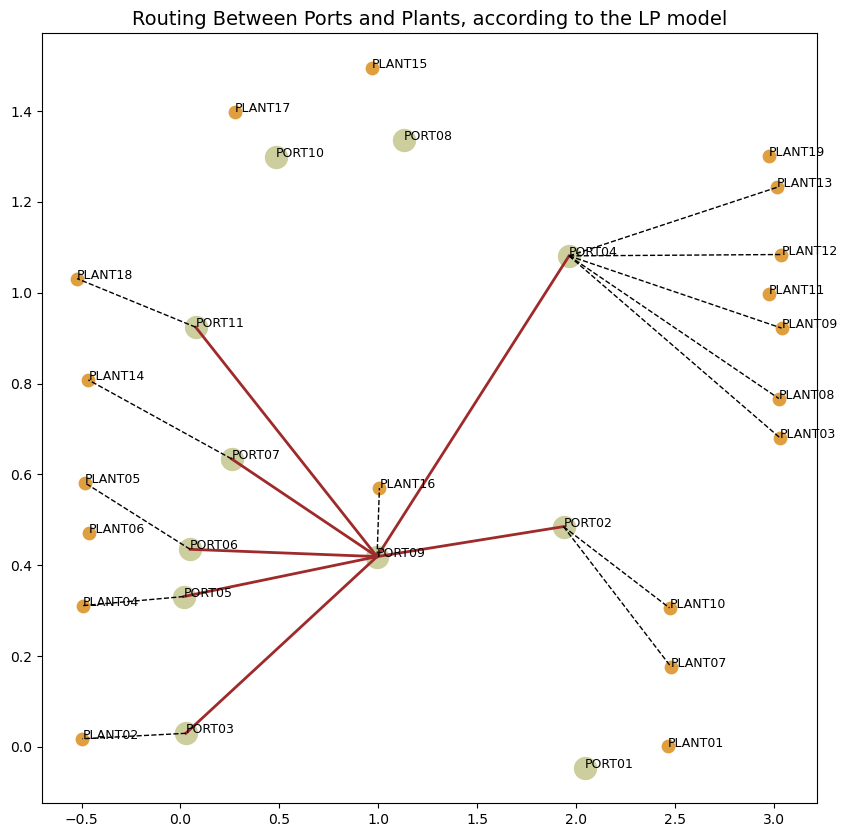

In [117]:
line_color = colors[0]  
port_dot_color = colors[5] 
plant_dot_color = colors[2] 

plt.figure(figsize=(10, 10))

for (fr, to) in final_routes.keys():
    plt.plot([PortsPos[fr][0], PortsPos[to][0]], [PortsPos[fr][1], PortsPos[to][1]], 
             linewidth=2, c=line_color) 
    port_plants_items = final_routes[(fr, to)]
    
    for plant in port_plants_items.keys():
        plt.plot([PortsPos[fr][0], PlantsPos[plant][0]], [PortsPos[fr][1], PlantsPos[plant][1]], 
                 'k--', linewidth=1)

plt.scatter([pos[0] for _, pos in PortsPos.items()], [pos[1] for _, pos in PortsPos.items()], 
            s=250, c=port_dot_color)
for port in ports:
    plt.annotate(port, PortsPos[port], fontsize=9)

plt.scatter([pos[0] for _, pos in PlantsPos.items()], [pos[1] for _, pos in PlantsPos.items()], 
            s=80, c=plant_dot_color) 
for plant in plants:
    plt.annotate(plant, PlantsPos[plant], fontsize=9)
plt.title("Routing Between Ports and Plants, according to the LP model", fontsize=14)
plt.show()

## 4. Linear Programming (LP): OR-Tools, CBC

In [118]:
file = pd.ExcelFile(r'C:\Users\tomol\OneDrive\Desktop\Supply chain logisitcs problem.xlsx')
df_dict = {}
for names in file.sheet_names:
    globals()[names] = file.parse(names)
    df_dict[names] = globals()[names]
print(df_dict.keys())

for df_name, df in df_dict.items():
    df.columns = [col.strip().replace(' ', '_').replace('/', '_').lower() for col in df.columns]

dict_keys(['OrderList', 'FreightRates', 'WhCosts', 'WhCapacities', 'ProductsPerPlant', 'VmiCustomers', 'PlantPorts'])


In [119]:
order_no = len(df_dict['OrderList'])
ports = list(df_dict['PlantPorts']['port'].unique()); ports.sort()
plants = list(df_dict['WhCosts']['wh'].unique()); plants.sort()
orders = df_dict['OrderList']['order_id'].tolist()[:order_no]

demand_ports = list(df_dict['OrderList']['destination_port'].unique()); demand_ports.sort()
carriers_info = {}
for port in ports:
  for demand_port in demand_ports:
    matches_df = df_dict['FreightRates'][(df_dict['FreightRates']['orig_port_cd'] == port) & (df_dict['FreightRates']['dest_port_cd'] == demand_port)]
    if matches_df.empty:
        continue
    max_qty = matches_df['max_wgh_qty'].max()
    min_qty = matches_df['minm_wgh_qty'].min()
    min_rate = matches_df['rate'].min()
    rate = matches_df['rate'].max()
    carriers_info[(port, demand_port)] = {"min": min_qty, "max": max_qty, "fixed_cost":min_rate, "rate": rate}

plants_cap = {plant: df_dict['WhCapacities'][df_dict['WhCapacities']['plant_id'] == plant]['daily_capacity'].values[0] for plant in plants}

VmiPlants = df_dict['VmiCustomers']['plant_code'].unique().tolist()
VmiCustomers = df_dict['VmiCustomers']['customers'].unique().tolist()
VmiPlantCustomers = {plant: df_dict['VmiCustomers'][df_dict['VmiCustomers']['plant_code'] == plant]['customers'].tolist() for plant in VmiPlants}
FreePlants = [plant for plant in plants if plant not in VmiPlants]

plant_products = {plant: df_dict['ProductsPerPlant'][df_dict['ProductsPerPlant']['plant_code'] == plant]['product_id'].tolist() for plant in plants}
port_plants = {port: df_dict['PlantPorts'][df_dict['PlantPorts']['port'] == port]['plant_code'].tolist() for port in ports}



possible_routes = {}
order_chances = {}
counter = 0
for index, order in df_dict['OrderList'].iterrows():
    if counter >= order_no:
        break
    counter += 1
    order_id = order['order_id']
    dest_port = order['destination_port']
    qty = order['unit_quantity']
    weight = order['weight']
    customer_id = order['customer']
    product_id = order['product_id']
    service_type = order['service_level']
    is_there_source = False
    order_chances[order_id] = []
    for port in ports:
        if (port, dest_port) in carriers_info:
          for plant in port_plants[port]:
            if product_id in plant_products[plant]:
              if (plant not in VmiPlants) or (plant in VmiPlants and customer_id in VmiPlantCustomers[plant]):
                is_there_source = True
                rate = carriers_info[(port, dest_port)]['rate'] if service_type != 'CRF' else 0.0
                transportation_cost = weight * rate      # weight * rate
                cost_per_unit   = df_dict['WhCosts'][df_dict['WhCosts']['wh'] == plant]['cost_unit'].values[0]
                warehousing_cost = qty * cost_per_unit   # quantity * cost_per_unit
                possible_routes[order_id, port, dest_port, plant] = {"transportation_cost": transportation_cost, "warehousing_cost": warehousing_cost, "qty": qty, "weight": weight}
                order_chances[order_id].append((order_id, port, dest_port, plant))

    if not is_there_source:
      print("No source available for product_id: ", product_id)

In [135]:
from ortools.linear_solver import pywraplp

start_time_ortools = time.time()

solver = pywraplp.Solver.CreateSolver('CBC')

customer_plant_ortools = []
X_ortools, O_ortools = {}, {}

for (order, orig_port, dest_port, plant) in possible_routes.keys():
    if (order, plant) not in customer_plant_ortools:
        customer_plant_ortools.append((order, plant))

for (order, orig_port, dest_port, plant) in possible_routes.keys():
    X_ortools[(order, orig_port, dest_port, plant)] = solver.BoolVar("X_ortools({},{},{},{})".format(order, orig_port, dest_port, plant))

for (order, plant) in customer_plant_ortools:
    O_ortools[(order, plant)] = solver.BoolVar("O_ortools({},{})".format(order, plant))

for (order, orig_port, dest_port, plant) in possible_routes.keys():
    solver.Add(X_ortools[(order, orig_port, dest_port, plant)] <= O_ortools[(order, plant)])

for order_id in orders:
    solver.Add(solver.Sum(X_ortools[(order, orig_port, dest_port, plant)] for (order, orig_port, dest_port, plant) in order_chances[order_id]) == 1)

for plant in plants:
    solver.Add(solver.Sum(X_ortools[(order, orig_port, port, supply_plant)] for (order, orig_port, port, supply_plant) in possible_routes.keys() if supply_plant == plant) <= 7 * plants_cap[plant])

for from_port, to_port in carriers_info.keys():
    solver.Add(solver.Sum(X_ortools[(order, orig_port, dest_port, plant)] * possible_routes[(order, orig_port, dest_port, plant)]['weight'] for (order, orig_port, dest_port, plant) in possible_routes.keys() if orig_port == from_port and dest_port == to_port) <= 2 * carriers_info[(from_port, to_port)]['max'])

    
    
WC_ortools = solver.Sum(X_ortools[(order, orig_port, dest_port, plant)] * possible_routes[(order, orig_port, dest_port, plant)]['warehousing_cost'] for (order, orig_port, dest_port, plant) in possible_routes.keys())
TC_ortools = solver.Sum(X_ortools[(order, orig_port, dest_port, plant)] * possible_routes[(order, orig_port, dest_port, plant)]['transportation_cost'] for (order, orig_port, dest_port, plant) in possible_routes.keys())
solver.Minimize(WC_ortools + TC_ortools)

status_ortools = solver.Solve()

end_time_ortools = time.time()
elapsed_time_ortools = end_time_ortools - start_time_ortools

if status_ortools == pywraplp.Solver.OPTIMAL:
    print("******************************************")
    objective_ortools = solver.Objective().Value()
    print(f"OR-Tools Objective Function: ${objective_ortools:,.2f}")
    print(f"OR-Tools Running Time: {elapsed_time_ortools:.2f} sec")

******************************************
OR-Tools Objective Function: $16,712,493.00
OR-Tools Running Time: 2.98 sec


In [136]:
results = {
    'Model': ['PuLP', 'OR-Tools'],
    'Objective Function Result': [obj, objective_ortools],
    'Time Taken (seconds)': [elapsed_time, elapsed_time_ortools]
}
df_results = pd.DataFrame(results)
print(df_results)

      Model  Objective Function Result  Time Taken (seconds)
0      PuLP               1.707434e+07              3.219297
1  OR-Tools               1.671249e+07              2.982937


## 5. Economic implications

In [134]:
baseline_warehousing_cost = 0
baseline_transportation_cost = 0
optimized_warehousing_cost = 0
optimized_transportation_cost = 0

for order_id in orders:
    possible_order_routes = order_chances[order_id]
    
    first_route = possible_order_routes[0]
    order, orig_port, dest_port, plant = first_route
    
    warehousing_cost = possible_routes[order, orig_port, dest_port, plant]['warehousing_cost']
    transportation_cost = possible_routes[order, orig_port, dest_port, plant]['transportation_cost']
    
    baseline_warehousing_cost += warehousing_cost
    baseline_transportation_cost += transportation_cost

for (order, orig_port, dest_port, plant), var in X.items():
    if var.varValue == 1: 
        warehousing_cost = possible_routes[order, orig_port, dest_port, plant]['warehousing_cost']
        transportation_cost = possible_routes[order, orig_port, dest_port, plant]['transportation_cost']
        
        optimized_warehousing_cost += warehousing_cost
        optimized_transportation_cost += transportation_cost

baseline_total_cost = baseline_warehousing_cost + baseline_transportation_cost
optimized_total_cost = optimized_warehousing_cost + optimized_transportation_cost

objective_value = value(prob.objective)
if abs(optimized_total_cost - objective_value) < 1e-6:  
    print("\nThe optimized total cost matches the objective function.")
else:
    print("\nOptimized total cost does not match the objective function.")

warehousing_savings = baseline_warehousing_cost - optimized_warehousing_cost
percentage_warehousing_savings = (warehousing_savings / baseline_warehousing_cost) * 100 if baseline_warehousing_cost != 0 else 0

transportation_savings = baseline_transportation_cost - optimized_transportation_cost
percentage_transportation_savings = (transportation_savings / baseline_transportation_cost) * 100 if baseline_transportation_cost != 0 else 0

total_savings = baseline_total_cost - optimized_total_cost
percentage_total_savings = (total_savings / baseline_total_cost) * 100 if baseline_total_cost != 0 else 0

print("\nComparison of Baseline vs Optimized Costs")

print("\n-- Warehousing Costs --")
print("Baseline Warehousing Cost: ${:,.2f}".format(baseline_warehousing_cost))
print("Optimized Warehousing Cost: ${:,.2f}".format(optimized_warehousing_cost))
print("Warehousing Cost saved: ${:,.2f} ({:.2f}%)".format(warehousing_savings, percentage_warehousing_savings))

print("\n-- Transportation Costs --")
print("Baseline Transportation Cost: ${:,.2f}".format(baseline_transportation_cost))
print("Optimized Transportation Cost: ${:,.2f}".format(optimized_transportation_cost))
print("Transportation Cost saved: ${:,.2f} ({:.2f}%)".format(transportation_savings, percentage_transportation_savings))

print("\n-- Total Costs --")
print("Baseline Total Cost: ${:,.2f}".format(baseline_total_cost))
print("Optimized Total Cost: ${:,.2f}".format(optimized_total_cost))
print("Total Cost saved: ${:,.2f} ({:.2f}%)".format(total_savings, percentage_total_savings))



The optimized total cost matches the objective function.

Comparison of Baseline vs Optimized Costs

-- Warehousing Costs --
Baseline Warehousing Cost: $15,586,233.34
Optimized Warehousing Cost: $15,501,599.52
Warehousing Cost saved: $84,633.82 (0.54%)

-- Transportation Costs --
Baseline Transportation Cost: $2,640,491.23
Optimized Transportation Cost: $1,572,739.93
Transportation Cost saved: $1,067,751.30 (40.44%)

-- Total Costs --
Baseline Total Cost: $18,226,724.57
Optimized Total Cost: $17,074,339.45
Total Cost saved: $1,152,385.13 (6.32%)
